<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [2]:
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [3]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape

(404, 13)

In [5]:
y_train[1]

42.3

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanAbsoluteError as MAE

In [7]:
mlp_model_0 = Sequential()
mlp_model_0.add(Dense(16,input_dim=13, activation='relu'))
mlp_model_0.add(Dense(8, activation='relu'))
mlp_model_0.add(Dense(4, activation='tanh'))
mlp_model_0.add(Dense(1, activation='relu'))
mlp_model_0.compile(loss='mean_squared_error', optimizer='adam', metrics=['MAE', 'MSE'])
mlp_model_0.fit(X_train, y_train, epochs=150)

W0123 12:57:57.961188  6632 deprecation.py:506] From c:\users\dylan nason\anaconda3\envs\u4-s2-nn\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/150
404/404 [==============================] - 0s 646us/sample - loss: 571.4045 - mean_absolute_error: 22.0773 - mean_squared_error: 571.4045
Epoch 2/150
404/404 [==============================] - 0s 69us/sample - loss: 561.1293 - mean_absolute_error: 21.8431 - mean_squared_error: 561.1293
Epoch 3/150
404/404 [==============================] - 0s 92us/sample - loss: 550.0164 - mean_absolute_error: 21.5872 - mean_squared_error: 550.0164
Epoch 4/150
404/404 [==============================] - 0s 82us/sample - loss: 537.7692 - mean_absolute_error: 21.3084 - mean_squared_error: 537.7692
Epoch 5/150
404/404 [==============================] - 0s 74us/sample - loss: 524.3968 - mean_absolute_error: 20.9933 - mean_squared_error: 524.3968
Epoch 6/150
404/404 [==============================] - 0s 77us/sample - loss: 509.7112 - mean_absolute_error: 20.6402 - mean_squared_error: 509.7112
Epoch 7/150
404/404 [==============================] - 0s 119us/sample - loss: 493.9084 - mean_absolute_e

In [8]:
scores = mlp_model_0.evaluate(X_test, y_test)
print(f"{mlp_model_0.metrics_names[1]}: {scores[1]}")

102/102 [==============================] - 0s 667us/sample - loss: 192.2155 - mean_absolute_error: 11.3199 - mean_squared_error: 192.2155
mean_absolute_error: 11.319940567016602


In [25]:
mlp_model_1 = Sequential()
mlp_model_1.add(Dense(16,input_dim=13, activation='relu'))
mlp_model_1.add(Dense(8, activation='relu'))
mlp_model_1.add(Dense(1, activation='relu'))
mlp_model_1.compile(loss='mean_squared_error', optimizer='adam', metrics=['MAE', 'MSE'])
best_history = mlp_model_1.fit(X_train, y_train, epochs=150)

Epoch 1/150
404/404 [==============================] - 0s 604us/sample - loss: 574.8237 - mean_absolute_error: 22.1499 - mean_squared_error: 574.8237
Epoch 2/150
404/404 [==============================] - 0s 114us/sample - loss: 568.1059 - mean_absolute_error: 21.9968 - mean_squared_error: 568.1058
Epoch 3/150
404/404 [==============================] - 0s 114us/sample - loss: 560.4886 - mean_absolute_error: 21.8269 - mean_squared_error: 560.4885
Epoch 4/150
404/404 [==============================] - 0s 77us/sample - loss: 551.9494 - mean_absolute_error: 21.6283 - mean_squared_error: 551.9493
Epoch 5/150
404/404 [==============================] - 0s 69us/sample - loss: 541.8731 - mean_absolute_error: 21.3970 - mean_squared_error: 541.8730
Epoch 6/150
404/404 [==============================] - 0s 67us/sample - loss: 530.2951 - mean_absolute_error: 21.1264 - mean_squared_error: 530.2952
Epoch 7/150
404/404 [==============================] - 0s 79us/sample - loss: 517.0249 - mean_absolute_

In [10]:
scores = mlp_model_1.evaluate(X_test, y_test)
print(f"{mlp_model_1.metrics_names[1]}: {scores[1]}")

102/102 [==============================] - 0s 716us/sample - loss: 55.1273 - mean_absolute_error: 5.4509 - mean_squared_error: 55.1273
mean_absolute_error: 5.450854301452637


In [64]:
mlp_model_2 = Sequential()
mlp_model_2.add(Dense(16,input_dim=13, activation='relu'))
mlp_model_2.add(Dense(32, activation='relu'))
mlp_model_2.add(Dense(8, activation='relu'))
mlp_model_2.add(Dense(1, activation='relu'))
mlp_model_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['MAE', 'MSE'])
mlp_model_2.fit(X_train, y_train, epochs=100)

Epoch 1/100
404/404 [==============================] - 1s 1ms/sample - loss: 586.1605 - mean_absolute_error: 22.3951 - mean_squared_error: 586.1606
Epoch 2/100
404/404 [==============================] - 0s 307us/sample - loss: 586.1605 - mean_absolute_error: 22.3950 - mean_squared_error: 586.1605
Epoch 3/100
404/404 [==============================] - 0s 114us/sample - loss: 586.1605 - mean_absolute_error: 22.3950 - mean_squared_error: 586.1605
Epoch 4/100
404/404 [==============================] - 0s 114us/sample - loss: 586.1605 - mean_absolute_error: 22.3951 - mean_squared_error: 586.1605
Epoch 5/100
404/404 [==============================] - 0s 322us/sample - loss: 586.1605 - mean_absolute_error: 22.3950 - mean_squared_error: 586.1605s - loss: 585.7494 - mean_absolute_error: 22.3462 - mean_squared_error: 585.749
Epoch 6/100
404/404 [==============================] - 0s 238us/sample - loss: 586.1605 - mean_absolute_error: 22.3950 - mean_squared_error: 586.1605
Epoch 7/100
404/404 [==

In [12]:
scores = mlp_model_2.evaluate(X_test, y_test)
print(f"{mlp_model_2.metrics_names[1]}: {scores[1]}")

102/102 [==============================] - 0s 852us/sample - loss: 615.8578 - mean_absolute_error: 23.0784 - mean_squared_error: 615.8578
mean_absolute_error: 23.078432083129883


In [26]:
import matplotlib.pyplot as plt

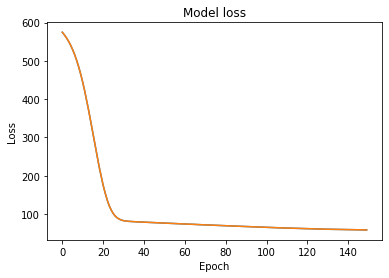

In [29]:
plt.plot(best_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

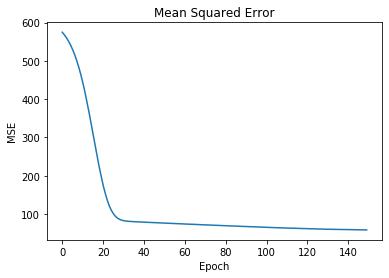

In [30]:
plt.plot(best_history.history['mean_squared_error'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

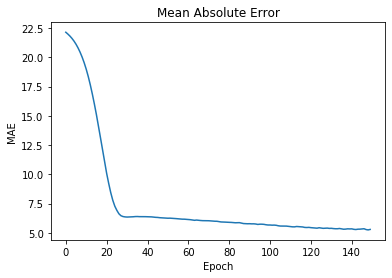

In [32]:
plt.plot(best_history.history['mean_absolute_error'])
plt.title('Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.show()

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)
r2_score(y_test, lr.predict(X_test))

0.7817795450774266

In [61]:
mean_absolute_error(y_test, lr.predict(X_test))

3.167870601061832

In [56]:
y_pred = [x[0] for x in mlp_model_2.predict(X_test)]

In [58]:
r2_score(y_test, y_pred)

-6.39130278492761

In [62]:
mean_absolute_error(y_test, y_pred)

23.06197515650488

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [82]:
from tensorflow.keras.datasets import fashion_mnist as fm
(X_train, y_train), (X_test, y_test) = fm.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [91]:
# Hyper Parameters
batch_size = 64
num_classes = 10
epochs = 10

In [87]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [92]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model_m_0 = Sequential()

# Input => Hidden
model_m_0.add(Dense(64, input_dim=784, activation='relu'))
# Hidden
model_m_0.add(Dense(32, activation='relu'))
# Hidden
model_m_0.add(Dense(16, activation='relu'))
# Output
model_m_0.add(Dense(10,activation='softmax'))

#Compile
model_m_0.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [101]:
history = model_m_0.fit(X_train, y_train, batch_size=16, epochs=epochs, verbose=True)
scores = model_m_0.evaluate(X_test, y_test)
print(f'{model_m_0.metrics_names[1]}: {scores[1]*100}')

Epoch 1/20
60000/60000 [==============================] - 16s 269us/sample - loss: 0.5429 - acc: 0.7720
Epoch 2/20
60000/60000 [==============================] - 25s 418us/sample - loss: 0.5459 - acc: 0.7710 - lo - ETA: 2s - loss: 0.5450 - acc:  - ETA: 2s - loss: 0.5449 - ETA: 2s - loss: 0.5448 - acc
Epoch 3/20
60000/60000 [==============================] - 31s 511us/sample - loss: 0.5489 - acc: 0.7728
Epoch 4/20
60000/60000 [==============================] - 45s 747us/sample - loss: 0.5474 - acc: 0.7714
Epoch 5/20
60000/60000 [==============================] - 33s 552us/sample - loss: 0.5433 - acc: 0.7735
Epoch 6/20
60000/60000 [==============================] - 28s 461us/sample - loss: 0.5448 - acc: 0.7758
Epoch 7/20
60000/60000 [==============================] - 28s 461us/sample - loss: 0.5404 - acc: 0.7771
Epoch 8/20
60000/60000 [==============================] - 29s 485us/sample - loss: 0.5460 - acc: 0.7769
Epoch 9/20
60000/60000 [==============================] - 27s 444us/sample

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.